In [32]:
import re
import requests
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup as soup
from typing import List, Union

In [2]:
BASE_URL_DST_FINAL = 'https://wdc.kugi.kyoto-u.ac.jp/dst_final/'

In [3]:
def get_month_data(year: str, month: str) -> Union[str, Exception]:
    """
    year str: YYYYY
    month str: DD
    """
    url = f"{BASE_URL_DST_FINAL}/{year}{month}/index.html"
    try:
        ans = requests.get(url=url)
        data = soup(ans.text, "html.parser")
        text_from_html = data.findAll("pre")[0].text
        return text_from_html
    except Exception as error:
        raise error

In [4]:
def clean_month_data_text(data_text: str) -> List[str]:
    raw_data = list()
    _ = [raw_data.append(i) for i in data_text.split('\n') if i != '']
    return raw_data[6:]

In [6]:
def clean_single_line(line: str) -> List[int]:
    """
    """
    # seleciona somente os valores de dst dentro da lista
    # quebra o texto em 3 blocos com 33 caracteres
    split_three_blocks = re.findall('.................................', line[2:])
    # remove o primeiro caracter de cada bloco
    clean_blocks = list()
    _ = [clean_blocks.append(i[1:]) for i in split_three_blocks]
    # separa os blocos em conjuntos de 4 caracteres
    # converte valores de string para inteiro
    separated_values = [int(i) for i in re.findall('....', ''.join(clean_blocks))]
    return separated_values

def clean_multiples_lines(lines: List[str]):
    lines_ok = list()
    _ = [lines_ok.append(clean_single_line(i)) for i in lines]
    return lines_ok


In [7]:
def generate_df(trusted_data: List[List[int]]) -> pd.DataFrame:
    """
    """
    df = pd.DataFrame(trusted_data, columns=list(range(1, 25)))
    df.index = df.index+1
    return df

In [174]:
def plot_dst_graph(df):
    # alta resolução
    axis_x = [(i+1)/df.columns.size for i in range(df.columns.size*len(df))]

    elements = [df.iloc[i].to_list() for i in range(len(df))]
    axis_y = list()
    for element in elements:
        axis_y += element

    plt.plot(axis_x, axis_y)

    # baixa resolução
    # df.min(axis=1).plot()

In [97]:
year = '2000'
month = '07'

month_data = get_month_data(year=year, month=month)
cleaned_data = clean_month_data_text(data_text=month_data)
trusted_data = clean_multiples_lines(lines=cleaned_data)


In [134]:
df = generate_df(trusted_data=trusted_data)

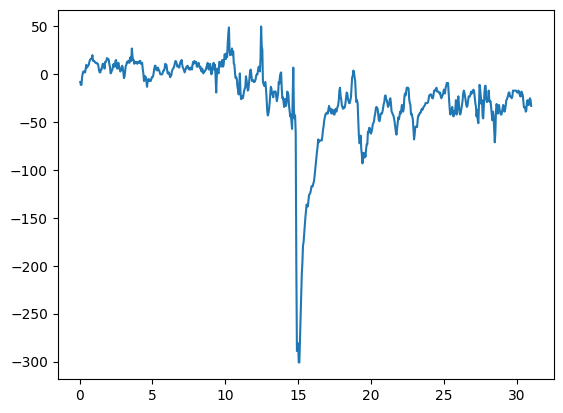

In [175]:
plot_dst_graph(df)